# compare the toxicity prediction between validation data and 

In [ ]:
import os
import sys

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

import ast
import collections
import itertools
import random
import time
import warnings
from statistics import variance

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import umap
import xgboost as xgb
from deap import algorithms, base, creator, tools
from ga import not_dup, rand_nodup
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from scipy.stats import norm
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             mean_squared_error)
from tqdm import tqdm
from util import pickle_load, robust_z

warnings.filterwarnings("ignore")

import math
from math import comb

import xgboost as xgb
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, auc,
                             confusion_matrix, f1_score, mean_absolute_error,
                             precision_score, r2_score, recall_score,
                             roc_auc_score, roc_curve)

In [1]:
test_num = "0901"
lig = "ago"

if test_num in ["0701", "0702", "0907", "1001", "1002"]:
    if lig == "ago":
        lig = "!"
    else:
        pass

seed = 42
date = 241219
num = 1

trys = str(date) + "_" + str(num)

if lig in ["ago", "anta"]:
    test_name = test_num + "_" + lig
else:
    test_name = test_num

for_toxpred_dir = f"../../data/result/{test_name}/GA_{trys}/toxpred_{seed}"

In [4]:
df_train = pd.read_csv(f"{for_toxpred_dir}/train.tsv", header=None, sep="\t")
df_eval = pd.read_csv(f"{for_toxpred_dir}/eval.tsv", header=None, sep="\t")
df_test = pd.read_csv(f"{for_toxpred_dir}/test.tsv", header=None, sep="\t")
df_ga = pd.read_csv(f"{for_toxpred_dir}/ga.tsv", header=None, sep="\t")

In [5]:
def prep_tp_data(df):
    X, y = [], []
    for i in range(len(df)):
        mol = Chem.MolFromSmiles(df.iloc[i,2])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        X.append(fp)
        y.append(df.iloc[i,1])
    return X, y

In [6]:
X_train, y_train = prep_tp_data(df_train)
X_eval, y_eval = prep_tp_data(df_eval)
X_test, y_test = prep_tp_data(df_test)
X_ga, y_ga = prep_tp_data(df_ga)

# regression task

In [ ]:
def objective(trial):
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }
    
    model = xgb.XGBRegressor(**param, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)
    y_pred = model.predict(X_eval)
    rmse = mean_squared_error(y_eval, y_pred, squared=False)
    return rmse

In [ ]:
def objective_ga(trial):
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }
    
    model = xgb.XGBRegressor(**param, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_ga, y_ga)], verbose=False)
    y_pred = model.predict(X_ga)
    rmse = mean_squared_error(y_ga, y_pred, squared=False)
    return rmse

In [ ]:
optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=8)

In [ ]:
best_params = study.best_params
print(f"Best Parameters: {best_params}")

In [ ]:
mod = xgb.XGBRegressor(**best_params)
mod.fit(X_train, y_train)
y_test_pred = mod.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test_pred, label="Predictions")
plt.plot(y_test, label="Actual Values", alpha=0.7)
plt.legend()
plt.title("Test Predictions vs Actual Values")
plt.xlabel("Samples")
plt.ylabel("Target Variable")
plt.show()

rmse_best = np.sqrt(mean_squared_error(y_valid, y_pred_best))
mae_best = mean_absolute_error(y_valid, y_pred_best)
r2_best = r2_score(y_valid, y_pred_best)

print(f"Best Model RMSE: {rmse_best}")
print(f"Best Model MAE: {mae_best}")
print(f"Best Model R²: {r2_best}")

# classification task

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.0001, 0.001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 0.001),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 0.001),
    }
    
    model = xgb.XGBClassifier(**params, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, val_set=[(X_eval, y_eval)], verbose=False)

    y_pred = model.predict(X_eval)
    accuracy = accuracy_score(y_eval, y_pred)

    return accuracy

In [10]:
def objective_ga(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.0001, 0.001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 0.001),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 0.001),
    }
    
    model = xgb.XGBClassifier(**params, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_ga, y_ga)], verbose=False)

    y_pred = model.predict(X_eval)
    accuracy = accuracy_score(y_ga, y_pred)

    return accuracy

In [11]:
optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective_ga, n_trials=30, show_progress_bar=True, n_jobs=8)

  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
best_params = study.best_params
print(f"Best Parameters: {best_params}")

Best Parameters: {'n_estimators': 190, 'max_depth': 79, 'learning_rate': 86.9650105430408, 'subsample': 0.5679362261596715, 'colsample_bytree': 0.692460249589465, 'gamma': 0.00024646694249484056, 'min_child_weight': 1, 'reg_alpha': 0.0006797740518815108, 'reg_lambda': 0.00010174950844288524}


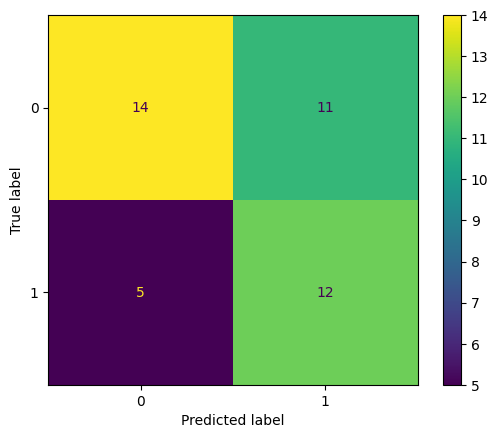

In [ ]:
# mod = xgb.XGBClassifier(**best_params)
# mod = mod.fit(X_train, y_train)
# y_pred = mod.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mod.classes_)
disp.plot()

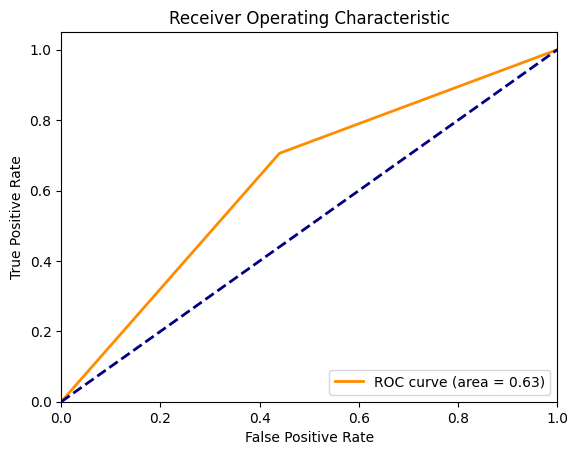

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc}")

# run all test 

In [3]:
def prep_tp_data(df):
    X, y = [], []
    for i in range(len(df)):
        mol = Chem.MolFromSmiles(df.iloc[i,2])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        X.append(fp)
        y.append(df.iloc[i,1])
    return X, y

In [4]:
def objective_reg(trial):
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }
    
    model = xgb.XGBRegressor(**param, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)
    y_pred = model.predict(X_eval)
    rmse = mean_squared_error(y_eval, y_pred, squared=False)
    return rmse

In [5]:
def objective_reg_ga(trial):
    param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }
    
    model = xgb.XGBRegressor(**param, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_ga, y_ga)], verbose=False)
    y_pred = model.predict(X_ga)
    rmse = mean_squared_error(y_ga, y_pred, squared=False)
    return rmse

In [6]:
def objective_cls(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.0001, 0.001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 0.001),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 0.001),
    }
    
    model = xgb.XGBClassifier(**params, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_eval, y_eval)], verbose=False)

    y_pred = model.predict(X_eval)
    accuracy = accuracy_score(y_eval, y_pred)

    return accuracy

In [10]:
def objective_cls_ga(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 10, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.0001, 0.001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 0.001),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 0.001),
    }
    
    model = xgb.XGBClassifier(**params, early_stopping_rounds=10, verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_ga, y_ga)], verbose=False)

    y_pred = model.predict(X_ga)
    accuracy = accuracy_score(y_ga, y_pred)

    return accuracy

In [11]:
optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [2:21:46<14:10:37, 8506.19s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [2:30:21<5:17:08, 3805.78s/it] 

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [2:39:05<2:33:48, 2307.03s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [7:18:39<6:40:55, 8018.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [9:23:33<4:20:58, 7829.21s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [10:49:49<1:55:27, 6927.39s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 7/7 [12:15:36<00:00, 6305.21s/it]  


<Figure size 640x480 with 0 Axes>

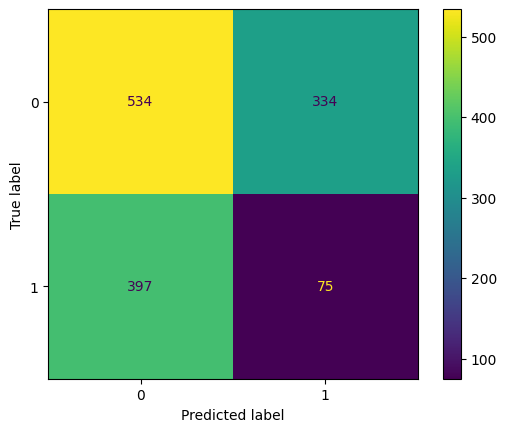

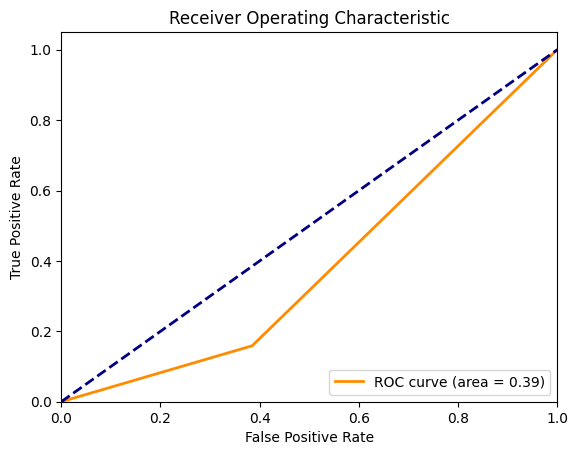

<Figure size 640x480 with 0 Axes>

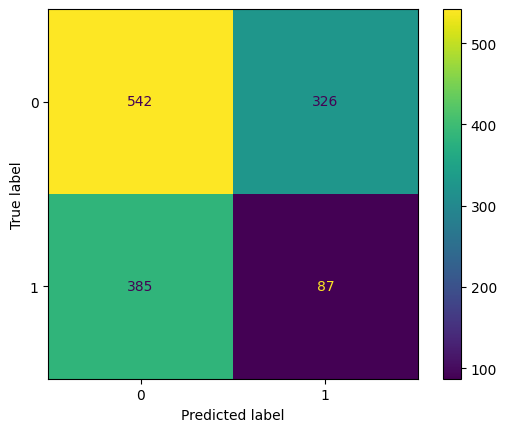

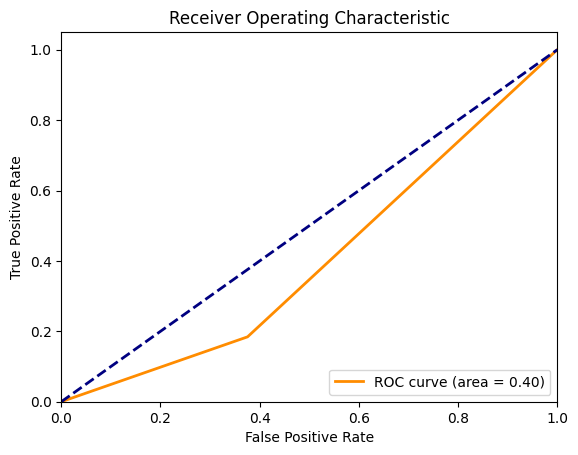

<Figure size 640x480 with 0 Axes>

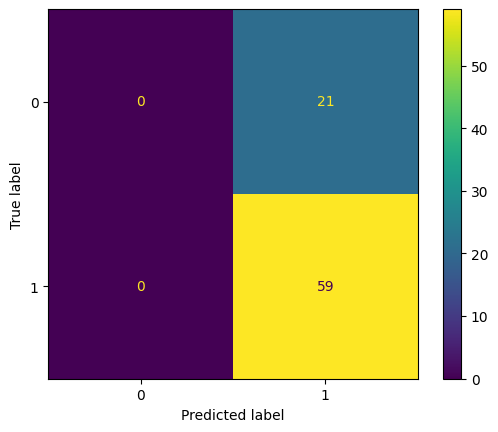

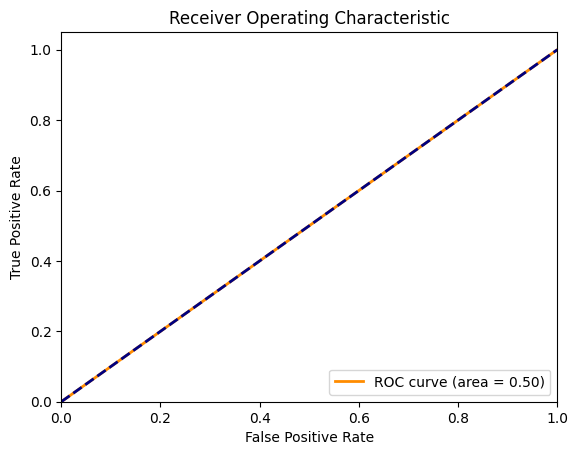

<Figure size 640x480 with 0 Axes>

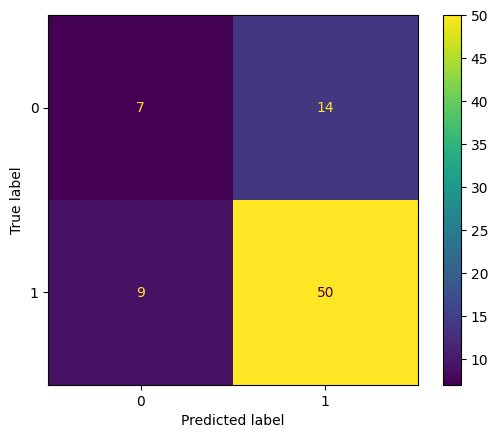

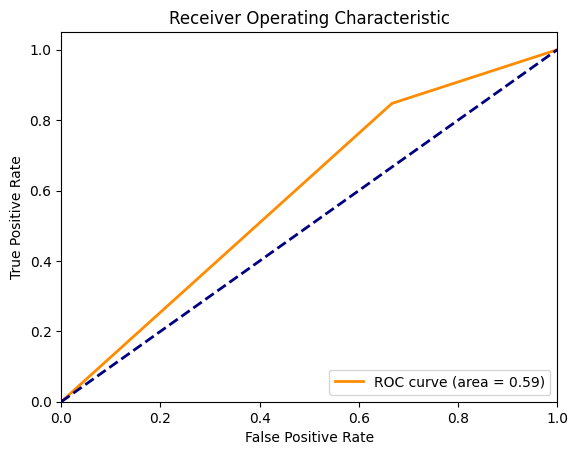

<Figure size 640x480 with 0 Axes>

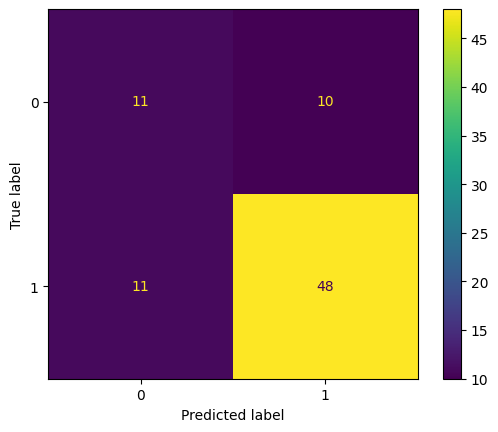

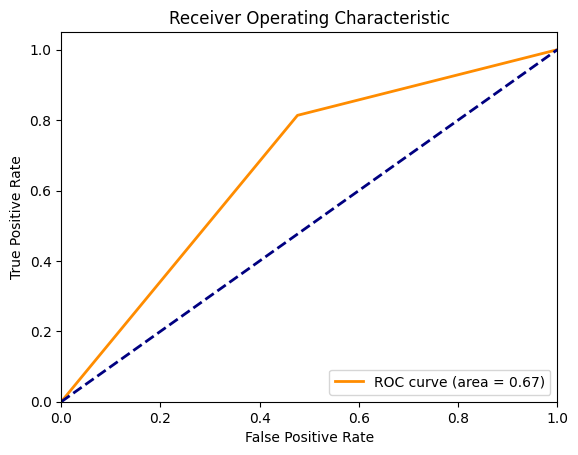

<Figure size 640x480 with 0 Axes>

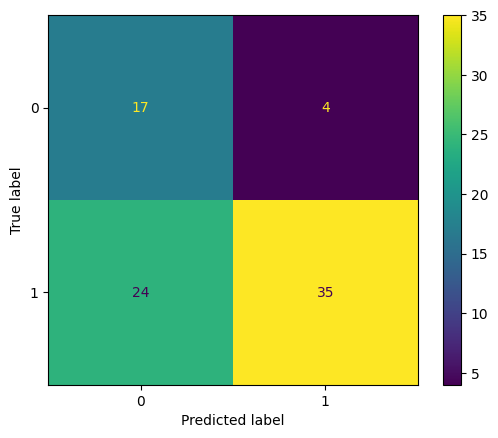

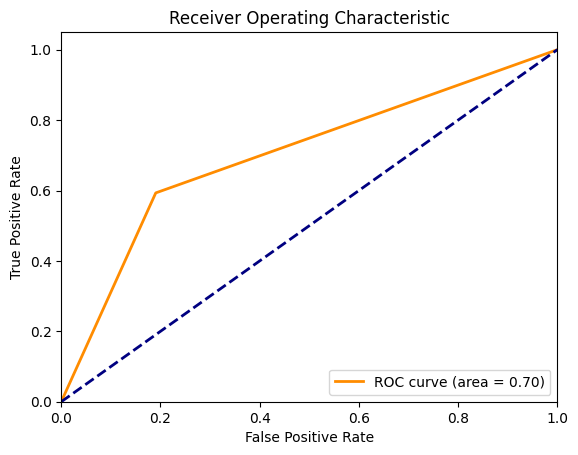

<Figure size 640x480 with 0 Axes>

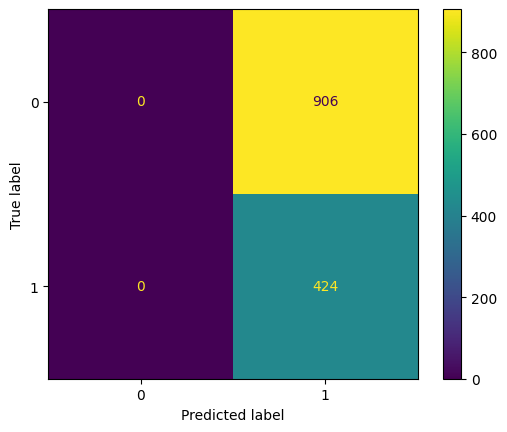

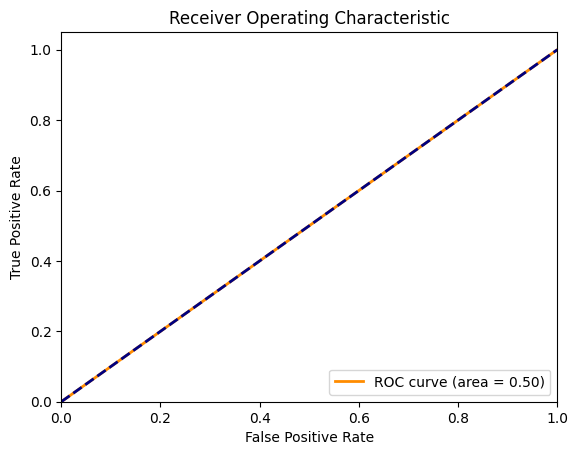

<Figure size 640x480 with 0 Axes>

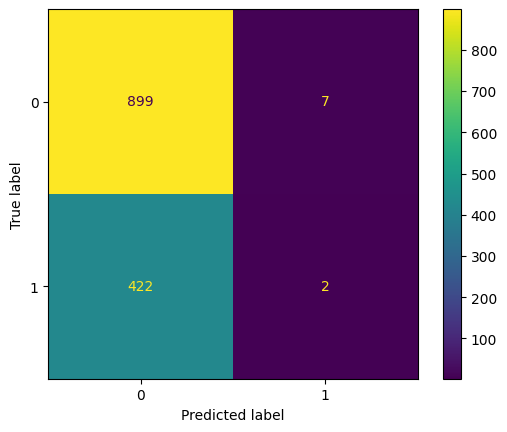

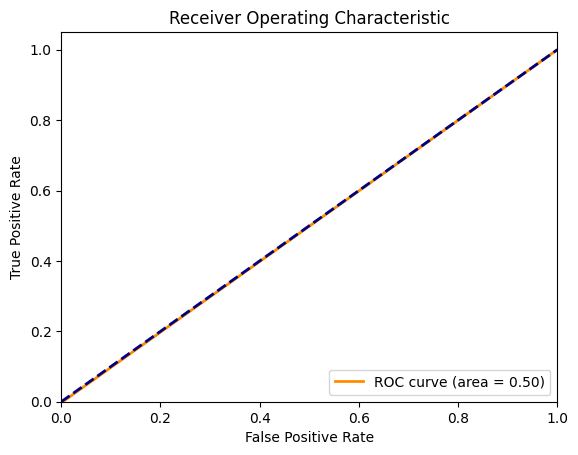

<Figure size 640x480 with 0 Axes>

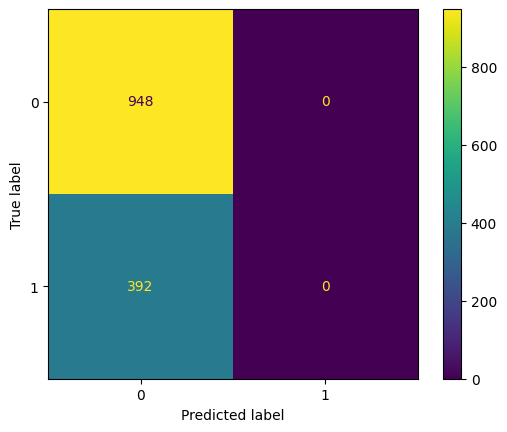

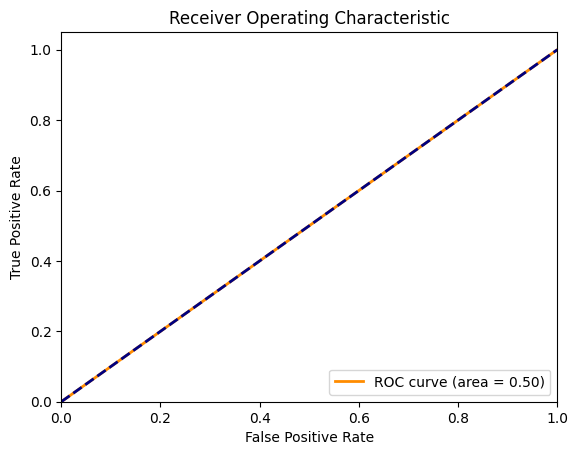

<Figure size 640x480 with 0 Axes>

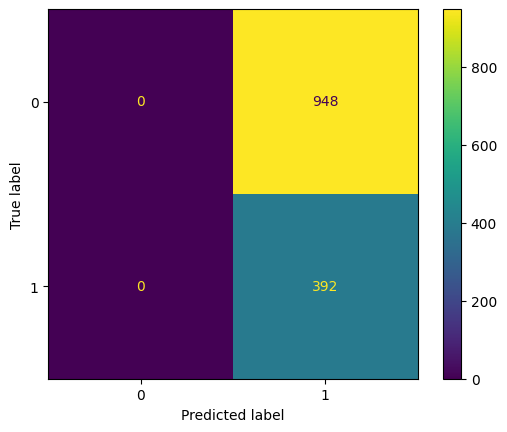

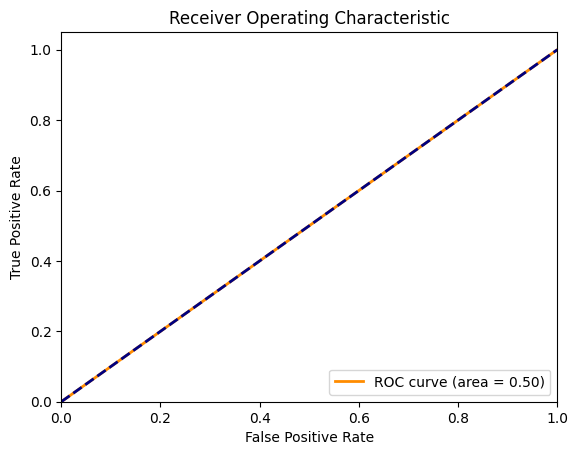

<Figure size 640x480 with 0 Axes>

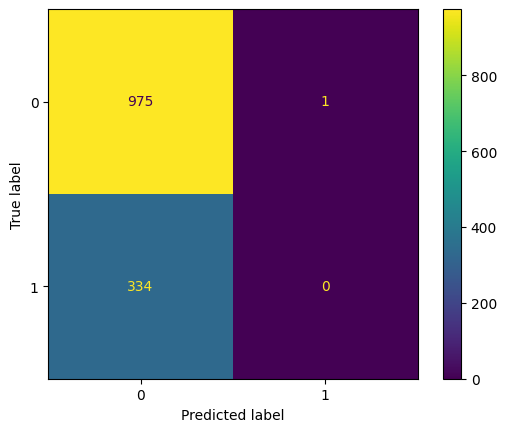

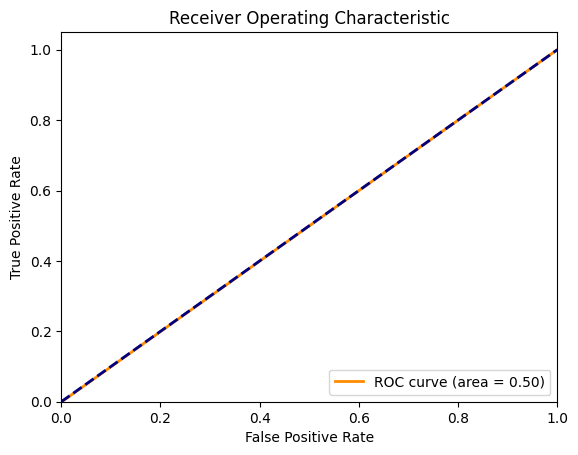

<Figure size 640x480 with 0 Axes>

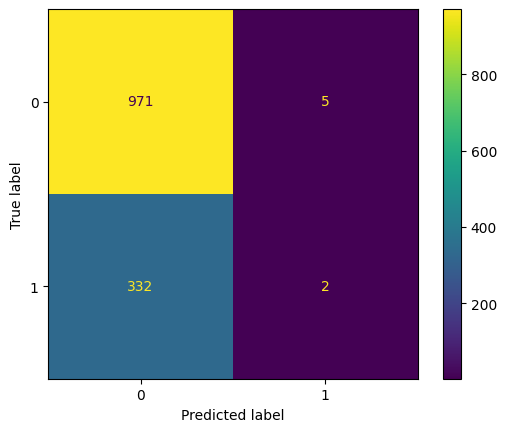

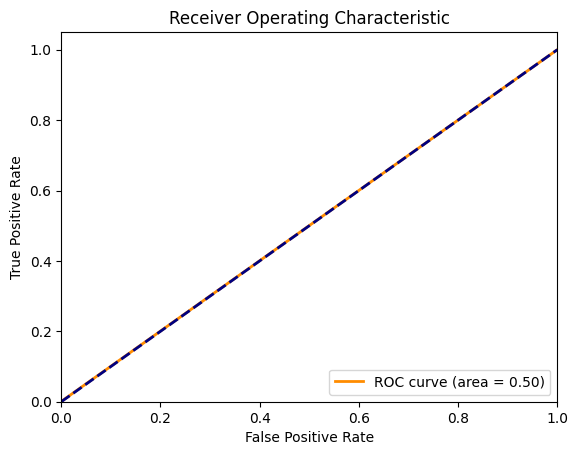

<Figure size 640x480 with 0 Axes>

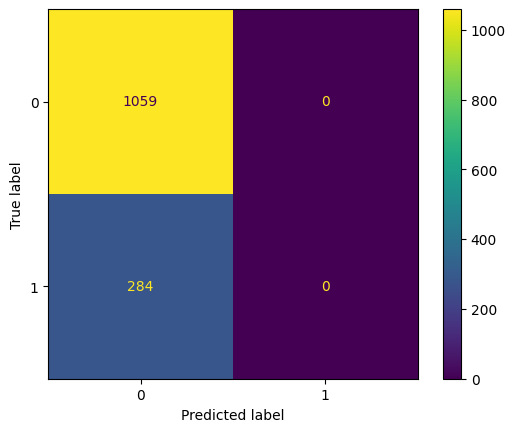

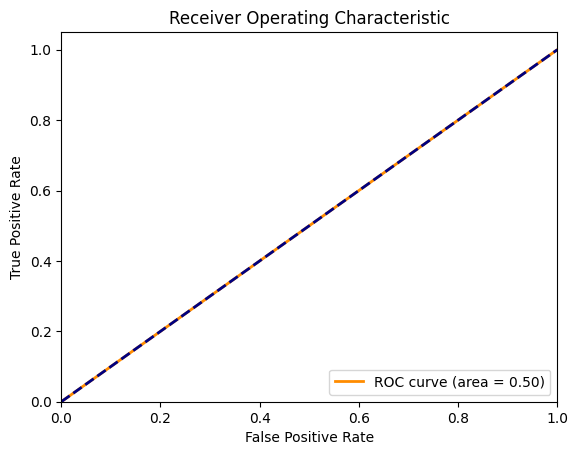

<Figure size 640x480 with 0 Axes>

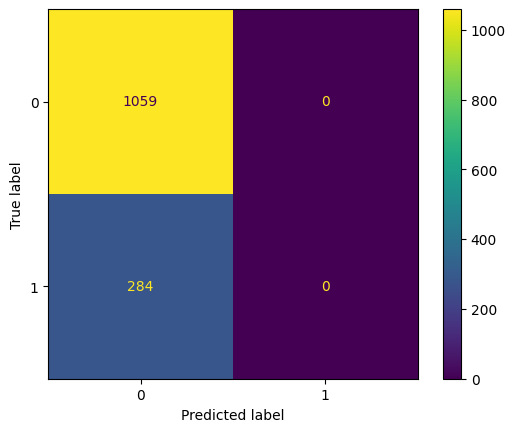

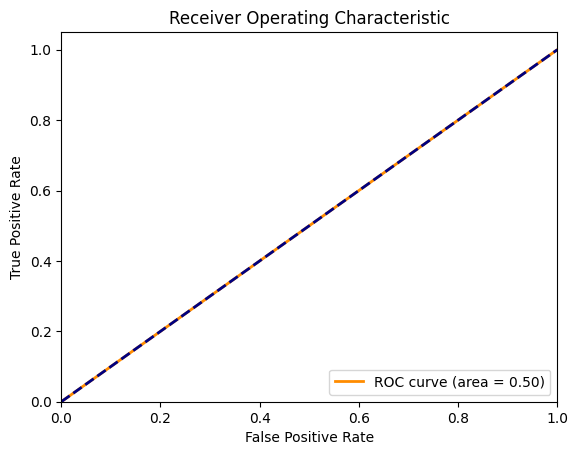

<Figure size 640x480 with 0 Axes>

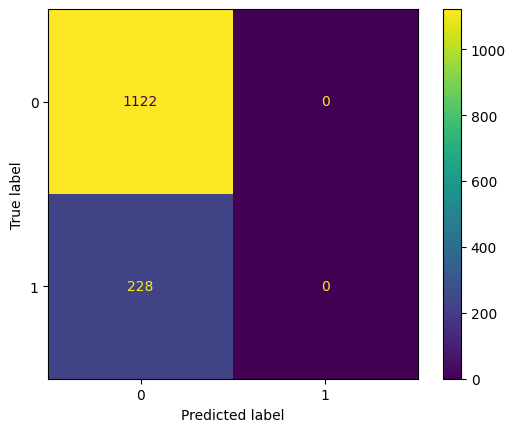

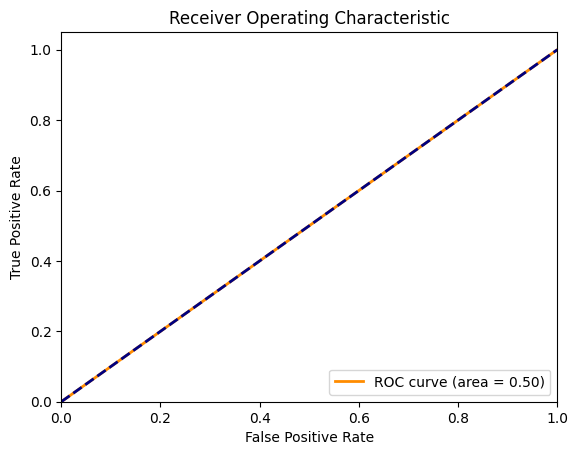

<Figure size 640x480 with 0 Axes>

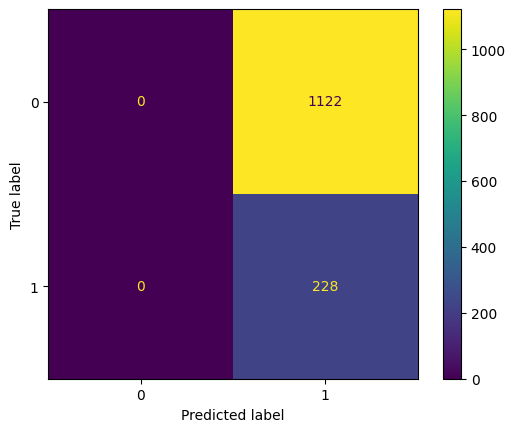

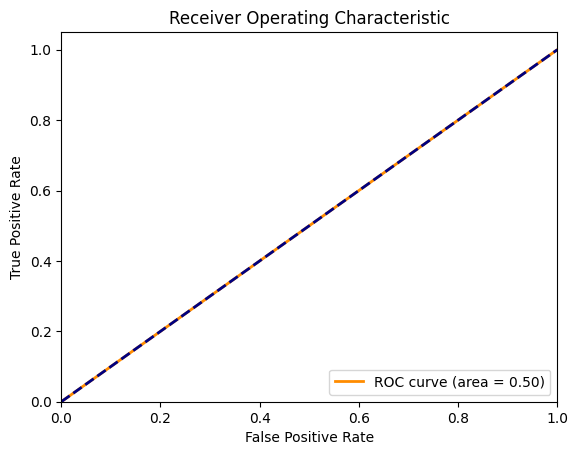

<Figure size 640x480 with 0 Axes>

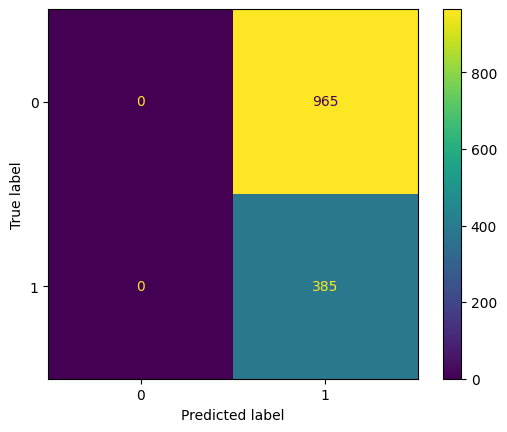

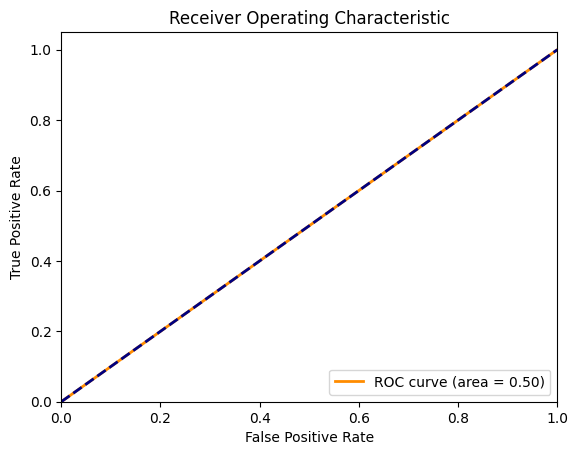

<Figure size 640x480 with 0 Axes>

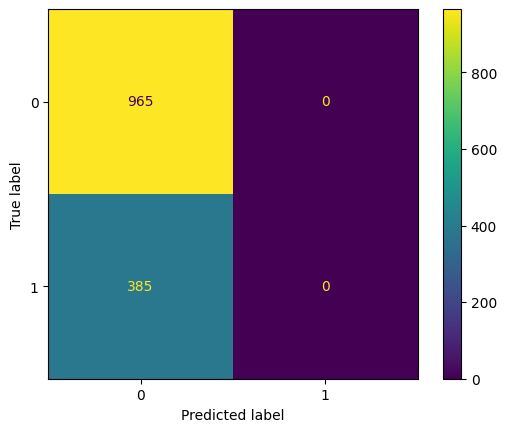

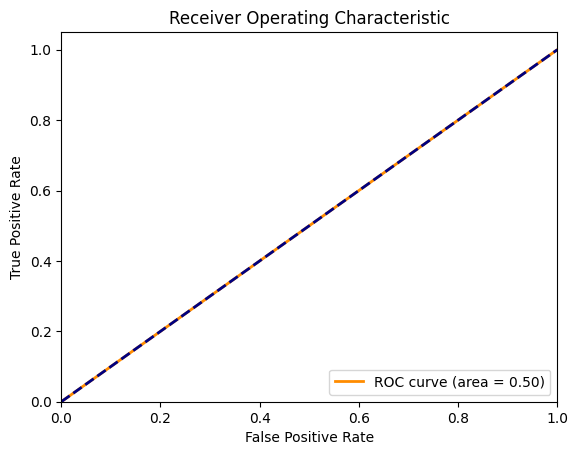

<Figure size 640x480 with 0 Axes>

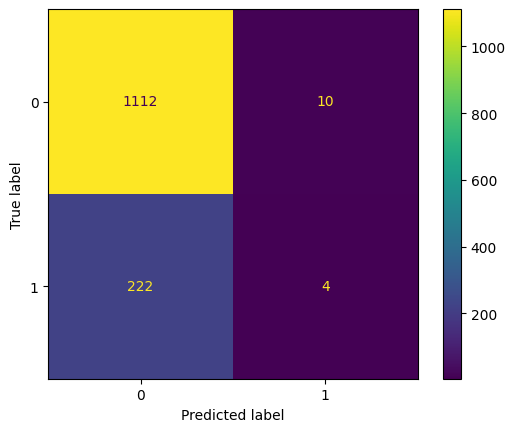

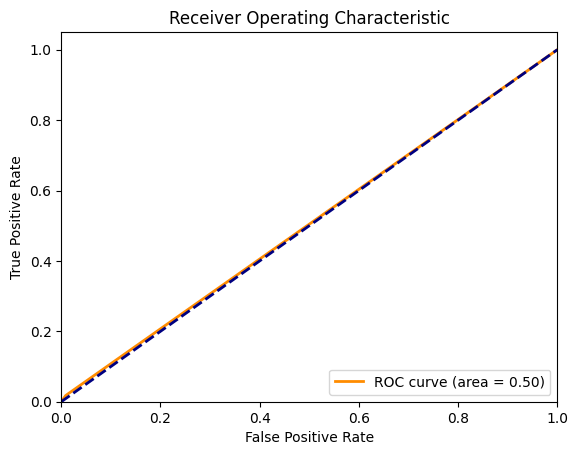

<Figure size 640x480 with 0 Axes>

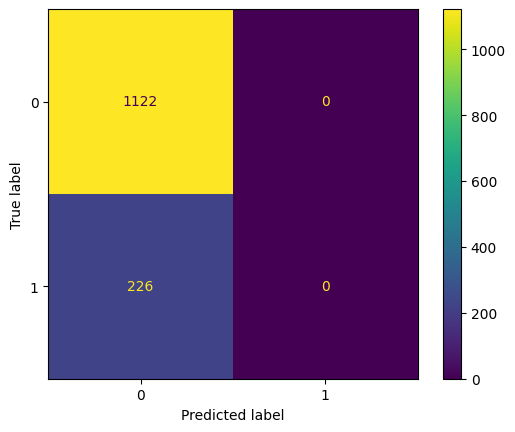

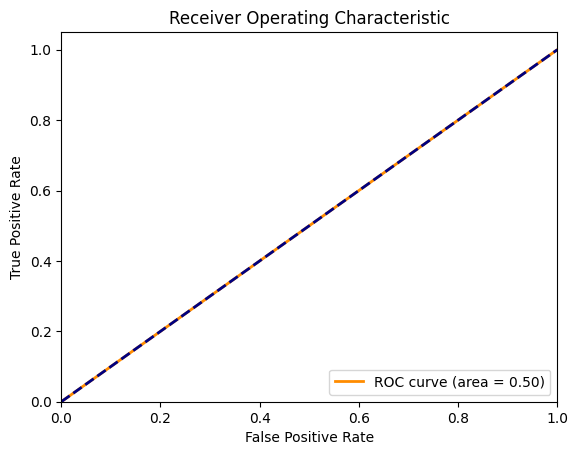

<Figure size 640x480 with 0 Axes>

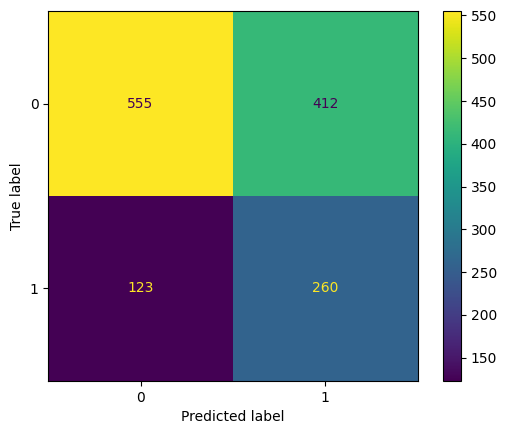

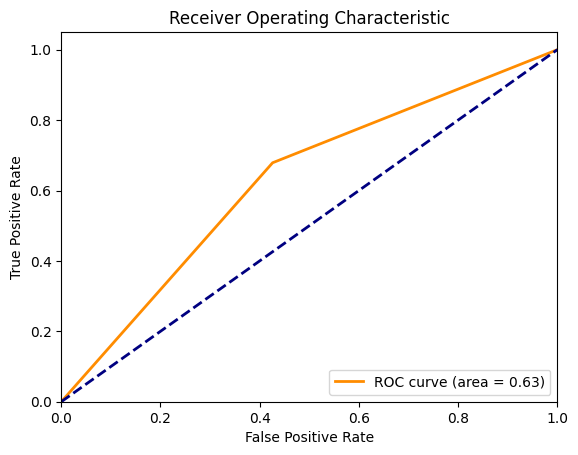

<Figure size 640x480 with 0 Axes>

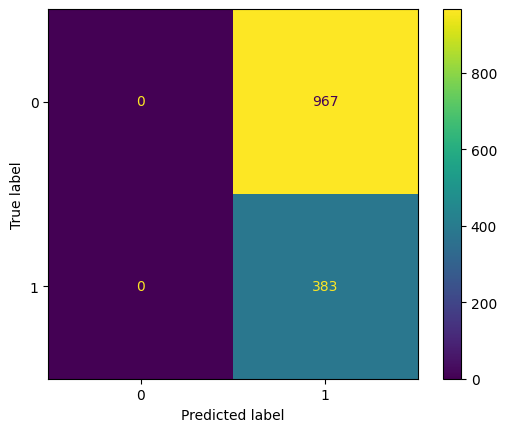

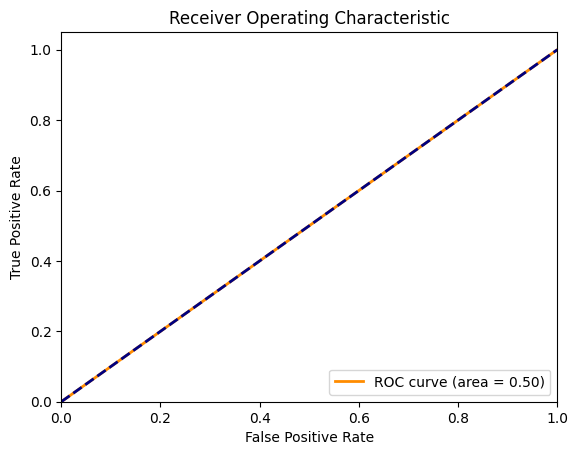

In [12]:
for test_num in tqdm(["0907", "1001", "1002", "0901", "0902", "0904", "0905"]): # "0701", "0702", 
    for lig in ["ago", "anta"]:
        if test_num in ["0701", "0702", "0907", "1001", "1002"]:
            if lig == "ago":
                lig = "!"
            else:
                continue
        seed = 42
        date = 241219
        num = 1

        trys = str(date) + "_" + str(num)

        if lig in ["ago", "anta"]:
            test_name = test_num + "_" + lig
        else:
            test_name = test_num

        for_toxpred_dir = f"../../data/result/{test_name}/GA_{trys}/toxpred_{seed}"

        df_train = pd.read_csv(f"{for_toxpred_dir}/train.tsv", header=None, sep="\t")
        df_eval = pd.read_csv(f"{for_toxpred_dir}/eval.tsv", header=None, sep="\t")
        df_test = pd.read_csv(f"{for_toxpred_dir}/test.tsv", header=None, sep="\t")
        df_ga = pd.read_csv(f"{for_toxpred_dir}/ga.tsv", header=None, sep="\t")

        X_train, y_train = prep_tp_data(df_train)
        X_eval, y_eval = prep_tp_data(df_eval)
        X_test, y_test = prep_tp_data(df_test)
        X_ga, y_ga = prep_tp_data(df_ga)

        c = collections.Counter(y_ga).keys()
        if len(c) == 2:
            task = "cls"
        else:
            task = "reg"

        if task == "cls":
            study = optuna.create_study(direction="maximize")
            study.optimize(objective_cls_ga, n_trials=30, show_progress_bar=True, n_jobs=32)
            
            best_params = study.best_params
            text_file_path = f'{for_toxpred_dir}/best_params_ga.txt'
            with open(text_file_path, mode='w') as file:
                file.write("Best Parameters:\n")
                for key, value in best_params.items():
                    file.write(f"{key}: {value}\n")

            # mod = xgb.XGBClassifier()
            mod = xgb.XGBClassifier(**best_params)
            mod = mod.fit(X_train, y_train)
            y_pred = mod.predict(X_test)
            y_proba = mod.predict_proba(X_test)
            y_t_proba = [n[1] for n in y_proba]

            plt.figure()
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mod.classes_)
            disp.plot()
            plt.savefig(f"{for_toxpred_dir}/confusion_matrix_ga.png", dpi=300, bbox_inches='tight')

            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.savefig(f"{for_toxpred_dir}/auroc_ga.png", dpi=300, bbox_inches='tight')

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            try:
                auroc = roc_auc_score(y_test, y_t_proba)
            except:
                auroc = 0

            col = [accuracy, precision, recall, f1, auroc]
            df = pd.DataFrame([col])
            df.columns = ["accuracy", "precision", "recall", "f1", "auc"]
            df.to_csv(f"{for_toxpred_dir}/result_ga.csv", index=False, header=True)

            study = optuna.create_study(direction="maximize")
            study.optimize(objective_cls, n_trials=30, show_progress_bar=True, n_jobs=32)
            
            best_params = study.best_params
            text_file_path = f'{for_toxpred_dir}/best_params.txt'
            with open(text_file_path, mode='w') as file:
                file.write("Best Parameters:\n")
                for key, value in best_params.items():
                    file.write(f"{key}: {value}\n")

            # mod = xgb.XGBClassifier()
            mod = xgb.XGBClassifier(**best_params)
            mod = mod.fit(X_train, y_train)
            y_pred = mod.predict(X_test)
            y_proba = mod.predict_proba(X_test)
            y_t_proba = [n[1] for n in y_proba]

            plt.figure()
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mod.classes_)
            disp.plot()
            plt.savefig(f"{for_toxpred_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')

            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.savefig(f"{for_toxpred_dir}/auroc.png", dpi=300, bbox_inches='tight')

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            try:
                auroc = roc_auc_score(y_test, y_t_proba)
            except:
                auroc = 0

            col = [accuracy, precision, recall, f1, auroc]
            df = pd.DataFrame([col])
            df.columns = ["accuracy", "precision", "recall", "f1", "auc"]
            df.to_csv(f"{for_toxpred_dir}/result.csv", index=False, header=True)
        
        if task == "reg":
            study = optuna.create_study(direction="minimize")
            study.optimize(objective_reg_ga, n_trials=30, show_progress_bar=True, n_jobs=32)

            best_params = study.best_params
            text_file_path = f'{for_toxpred_dir}/best_params_ga.txt'
            with open(text_file_path, mode='w') as file:
                file.write("Best Parameters:\n")
                for key, value in best_params.items():
                    file.write(f"{key}: {value}\n")

            # mod = xgb.XGBRegressor()
            mod = xgb.XGBRegressor(**best_params)
            mod.fit(X_train, y_train)
            y_pred_test = mod.predict(X_test)

            plt.figure()
            plt.plot(y_pred_test, label="Predictions")
            plt.plot(y_test, label="Actual Values", alpha=0.7)
            plt.legend()
            plt.title("Test Predictions vs Actual Values")
            plt.xlabel("Samples")
            plt.ylabel("Target Variable")
            plt.savefig(f"{for_toxpred_dir}/difference_ga.png", dpi=300, bbox_inches='tight')

            rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test))
            mae_best = mean_absolute_error(y_test, y_pred_test)
            r2_best = r2_score(y_test, y_pred_test)

            col = [rmse_best, mae_best, r2_best]
            df = pd.DataFrame([col])
            df.columns = ["rmse_best", "mae_best", "r2_best"]
            df.to_csv(f"{for_toxpred_dir}/result_ga.csv", index=False, header=True)

            study = optuna.create_study(direction="minimize")
            study.optimize(objective_reg, n_trials=30, show_progress_bar=True, n_jobs=32)

            best_params = study.best_params
            text_file_path = f'{for_toxpred_dir}/best_params.txt'
            with open(text_file_path, mode='w') as file:
                file.write("Best Parameters:\n")
                for key, value in best_params.items():
                    file.write(f"{key}: {value}\n")

            # mod = xgb.XGBRegressor()
            mod = xgb.XGBRegressor(**best_params)
            mod.fit(X_train, y_train)
            y_pred_test = mod.predict(X_test)
            
            plt.figure()
            plt.plot(y_pred_test, label="Predictions")
            plt.plot(y_test, label="Actual Values", alpha=0.7)
            plt.legend()
            plt.title("Test Predictions vs Actual Values")
            plt.xlabel("Samples")
            plt.ylabel("Target Variable")
            plt.savefig(f"{for_toxpred_dir}/difference.png", dpi=300, bbox_inches='tight')

            rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_test))
            mae_best = mean_absolute_error(y_test, y_pred_test)
            r2_best = r2_score(y_test, y_pred_test)

            col = [rmse_best, mae_best, r2_best]
            df = pd.DataFrame([col])
            df.columns = ["rmse_best", "mae_best", "r2_best"]
            df.to_csv(f"{for_toxpred_dir}/result.csv", index=False, header=True)
